In [58]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history
from datasets import MoveAsTensorDataset
import board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model

import random

import chess
import chess.engine
from stockfish import Stockfish

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
classified_moves = load_sql_to_df("SELECT position, move, sentiment FROM classified_moves", "../../chess.db")
classified_moves

,position,move,sentiment
0,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,0
1,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,1
2,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,1
3,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,1
4,r1q1r1k1/pp3pp1/2p2n2/2Nn3p/1PQN2b1/6P1/P2RPP1...,a7a6,1
...,...,...,...
272591,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,0
272592,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,0
272593,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,1
272594,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,1


In [4]:
train_df, test_df = train_test_split(classified_moves, test_size=0.05, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
47922,1k6/7p/6p1/p1p5/4p3/1bP5/5KPP/5N2 w - - 0 39,f1d2,0
76235,rn2k2r/pp6/3b4/2p3pp/5p1q/2N4B/PPPP1NPP/R1B2RK...,h3f5,1
4008,r7/5kpp/4p3/3p4/p3q3/6P1/2r4P/1R5K w - - 6 55,h1g1,1
110114,r1bqkbnr/pp3ppp/1np1p3/8/3P1B2/2NB1N2/PPP2PPP/...,b6d5,1
164888,r1bqkbnr/1p1p1ppp/p1n1p3/2p5/2B1P3/2PQ3N/PP1P1...,d3f3,1
...,...,...,...
211543,1r3rk1/p1p1p2p/1pB2npb/2n2b2/2N5/2N5/PPP2PPP/R...,c3b5,1
86293,rnbqkbnr/pppp1ppp/8/4p3/2B1P3/8/PPPP1PPP/RNBQK...,g8f6,0
122579,r1bqk2r/pp4b1/2np1np1/2p1p2p/2P1p3/BPN4P/P2PBP...,f2f3,1
152315,2kr1b2/ppp4p/1n2q1p1/3pP3/P4r2/1P1P3P/3N3R/1KQ...,d2f1,0


,position,move,sentiment
5716,r1b1kbnr/ppp2ppp/2n1p3/3q4/3P4/2N5/PP2PPPP/R1B...,c3d5,1
165834,5rk1/pp1q2pp/4p3/3pPp2/2rP1P2/P2Q4/1P4PP/R4R1K...,e5f6,0
236758,2r1k2r/pp1n1pp1/4p3/3pP3/5P1p/1NP1q2P/PPQ3PK/4...,e3g3,1
116351,8/6kp/1pQ3p1/4pp2/7P/P2p2P1/R4KP1/8 w - - 0 42,a2d2,1
9800,7k/1p2q1r1/3pPp2/3P1B2/5Q2/2b4P/6PK/3r4 w - - ...,f4h6,1
...,...,...,...
184051,1n1r2k1/r3bp1p/p3p1p1/2p5/2P1QP2/1P1BP2P/PB1q2...,f1d1,1
77796,2r1k2r/1bq1bppp/pn1pp3/4n1PP/1p1NP3/2PBBP2/PP4...,b6c4,1
176225,2r1rbk1/pp1q1ppp/5n2/2p4b/PnNpP3/1P1P1NPP/1B3P...,f3e5,0
224559,1k1r4/1p6/3b2Q1/R1p4p/6p1/3P2P1/1q3PPK/8 w - -...,g6h5,0


In [5]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [6]:
class SentimateNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(26, 26, 5, padding='same'),
            nn.Conv2d(26, 26, 3, padding='same'),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(8*8*26, 500),
            nn.ELU(),
            nn.Linear(500, 200),
            nn.ELU(),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 8*8*26)
        x = self.fc_layers(x)
        return x

In [18]:
model = SentimateNet()
model = model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=500, out_features=200, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=2048)
test_loader = DataLoader(test_dataset, batch_size=2048)

In [21]:
test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 44.69%, Avg loss: 0.693913
Test Error: Accuracy: 44.45%, Avg loss: 0.693929


In [22]:
history = train_loop(train_loader, model, test_dataloader=test_loader, num_epochs=100, optimizer=optimizer, verbose=True)

Epoch 1/100
Train loss: 0.686020, accuracy: 56.02%
Test loss:  0.683569, accuracy: 56.31%
-----------------------------
Epoch 2/100
Train loss: 0.684566, accuracy: 56.20%
Test loss:  0.683250, accuracy: 56.49%
-----------------------------
Epoch 3/100
Train loss: 0.683953, accuracy: 56.27%
Test loss:  0.682075, accuracy: 56.82%
-----------------------------
Epoch 4/100
Train loss: 0.683167, accuracy: 56.38%
Test loss:  0.682129, accuracy: 56.66%
-----------------------------
Epoch 5/100
Train loss: 0.682553, accuracy: 56.44%
Test loss:  0.682228, accuracy: 56.68%
-----------------------------
Epoch 6/100
Train loss: 0.682002, accuracy: 56.56%
Test loss:  0.682268, accuracy: 56.54%
-----------------------------
Epoch 7/100
Train loss: 0.681727, accuracy: 56.56%
Test loss:  0.681932, accuracy: 56.65%
-----------------------------
Epoch 8/100
Train loss: 0.681304, accuracy: 56.60%
Test loss:  0.683167, accuracy: 56.38%
-----------------------------
Epoch 9/100
Train loss: 0.681072, accura

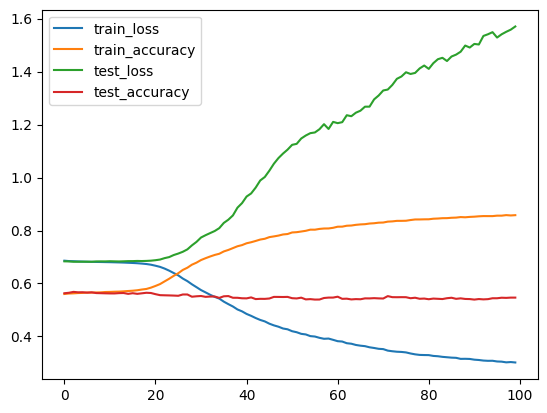

In [23]:
plot_history(history)

In [24]:
torch.save(model.state_dict(), "../../models/Sentimate_bad.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [115]:
from collections import Counter

def batch_legal_moves(board: chess.Board):
    move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
    return torch.stack(move_tensors)

def model_best_move(board: chess.Board, model: nn.Module):
    batch_moves = batch_legal_moves(board).to(device)
    batch_moves = batch_moves.to(device)

    model.eval()
    with torch.inference_mode():
        out = model(batch_moves)
        best_move_ind = out.argmax().item()
        best_move = list(board.legal_moves)[best_move_ind]

        return best_move
    

def compare_moves(board, move1, move2):
    engine = chess.engine.SimpleEngine.popen_uci("stockfish")
    result1 = engine.analyse(board, chess.engine.Limit(time=2), root_moves=[move1])
    result2 = engine.analyse(board, chess.engine.Limit(time=2), root_moves=[move2])
    
    if result1["score"].relative > result2["score"].relative:
        return -1
    elif result1["score"].relative < result2["score"].relative:
        return 1
    else:
        return 0
    
def compare_model_to_random_agent(model: nn.Module, fens, random_moves_from_position = 1):
    results = []
    for fen in fens:
        board = chess.Board(fen)

        legal_moves = list(board.legal_moves)

        model_move = model_best_move(board, model)

        for _ in range(random_moves_from_position):
            random_move = random.choice(legal_moves)
            comparison = compare_moves(board, model_move, random_move)
            results.append(comparison)

    stats = Counter(results)

    return {"model_better": stats[-1], "random_better": stats[1], "draw": stats[0]}




In [116]:
pos_to_test = list(test_df.position.sample(n = 10, random_state=0))
compare_model_to_random_agent(model, pos_to_test)

{'model_better': 4, 'random_better': 6, 'draw': 0}

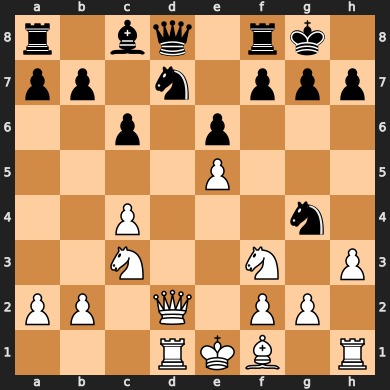

1

In [99]:
board = chess.Board("r1bq1rk1/pp1n1ppp/2p1p3/4P3/2P3n1/2N2N1P/PP1Q1PP1/3RKB1R b K - 0 11")
display(board)
model_best_move = model_best_move(board, model)
random_move = random.choice(list(board.legal_moves))
compare_moves(board, model_best_move, random_move)